In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

In [29]:

df = pd.read_excel('results/SA/100ex30-SA100/output_100ex30_150.xlsx')
# drop the columns that are not needed

print(len(df))
# only keep the valid ones
df = df[df['valid_solution'] == 1]
print(df.columns)
print(len(df))

4000
Index(['Unnamed: 0', 'instance', 'movements reached', 'median delay',
       'average delay', 'obj_val', 't0', 'alpha', 'valid_solution',
       'number_of_movements', 'number_of_headways', 'number_of_vessels',
       'average_headway', 'std_dev_headway', 'spread',
       'average_time_between_movements', 'average_travel_time'],
      dtype='object')
2858


In [30]:
# only keep the instances that are valid

In [52]:
# recalculate the objective function
movements_factor = 0.001
headway_factor = 0.00
df['objective_function'] = df['average delay'] \
                           + df['movements reached'] * movements_factor + df['number_of_headways'] * headway_factor
print(df['objective_function'], df['average delay'])

0       0.686667
1       0.853333
2       1.065833
3       0.736667
4       0.874167
          ...   
3995    0.870485
3996    0.434879
3997    0.616697
3998    0.525788
3999    1.044727
Name: objective_function, Length: 2858, dtype: float64 0       0.666667
1       0.833333
2       1.045833
3       0.716667
4       0.854167
          ...   
3995    0.848485
3996    0.412879
3997    0.594697
3998    0.503788
3999    1.022727
Name: average delay, Length: 2858, dtype: float64


In [53]:
feature_cols= ['t0', 'alpha','number_of_headways',
               'number_of_movements', 'number_of_vessels', 'average_headway', 'std_dev_headway', 'spread',
                'average_time_between_movements', 'average_travel_time']

X = df[feature_cols].values
y = df['objective_function'].values

In [89]:
# import warnings
# warnings.filterwarnings("ignore")
# 
# # Convert data to torch tensors
# class Data(Dataset):
#     def __init__(self, X, y):
#         self.X = X.astype(np.float32)
#         self.y = y.astype(np.float32)
#         # or directly from pandas to torch
#         X = torch.from_numpy(X)
#         y = torch.from_numpy(y)
#         self.len = self.X.shape[0]
#        
#     def __getitem__(self, index):
#         return self.X[index], self.y[index]
#    
#     def __len__(self):
#         return self.len
# 
# # Define batch size
# batch_size = 32
# 
# # Instantiate training and test data
# train_data = Data(X_train_scaled, y_train_scaled)
# train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
# 
# test_data = Data(X_test_scaled, y_test_scaled)
# test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
# 
# # Check it's working
# for batch, (X, y) in enumerate(train_dataloader):
#     print(f"Batch: {batch+1}")
#     print(f"X shape: {X.shape}")
#     print(f"y shape: {y.shape}")
#     break


In [56]:
import torch
import torch.nn as nn

class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.fc1 = nn.Linear(10, 64)  # Input layer to hidden layer 1
        self.act1 = nn.ReLU()  # Using Tanh activation function
        
        
        self.fc3 = nn.Linear(64, 16)  # Hidden layer 2 to hidden layer 3
        self.act3 = nn.ReLU()  # Using Rectified Linear Unit (ReLU) activation function
        
        self.fc4 = nn.Linear(16, 1)  # Hidden layer 3 to output

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act3(self.fc3(x))
        x = self.fc4(x)
        return x

# Instantiate the model
model = Regressor()
print(model)

Regressor(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (act1): ReLU()
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (act3): ReLU()
  (fc4): Linear(in_features=16, out_features=1, bias=True)
)


In [55]:
# define the network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
model = Net()
# to cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

Net(
  (fc1): Linear(in_features=9, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [57]:
import tqdm

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# train-test split of the dataset
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)


X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
            if epoch % 10 == 0:
                history.append(float(loss))
                print(f"Epoch: {epoch}, Loss: {loss.item():.4f}")
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = model.state_dict().copy()
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

Epoch: 0, Loss: 0.5215
Epoch: 0, Loss: 0.7190
Epoch: 0, Loss: 0.6437
Epoch: 0, Loss: 0.5314
Epoch: 0, Loss: 0.5629
Epoch: 0, Loss: 0.9784
Epoch: 0, Loss: 0.5249
Epoch: 0, Loss: 0.5065
Epoch: 0, Loss: 0.4258
Epoch: 0, Loss: 0.6583
Epoch: 0, Loss: 0.5850
Epoch: 0, Loss: 0.5668
Epoch: 0, Loss: 0.5892
Epoch: 0, Loss: 0.5427
Epoch: 0, Loss: 0.3375
Epoch: 0, Loss: 0.4656
Epoch: 0, Loss: 0.5067
Epoch: 0, Loss: 0.5020
Epoch: 0, Loss: 0.5443
Epoch: 0, Loss: 0.3391
Epoch: 0, Loss: 0.6881
Epoch: 0, Loss: 0.9823
Epoch: 0, Loss: 0.5661
Epoch: 0, Loss: 0.4554
Epoch: 0, Loss: 0.7426
Epoch: 0, Loss: 0.5869
Epoch: 0, Loss: 0.6839
Epoch: 0, Loss: 0.4962
Epoch: 0, Loss: 0.6888
Epoch: 0, Loss: 0.4606
Epoch: 0, Loss: 0.7191
Epoch: 0, Loss: 0.5020
Epoch: 0, Loss: 0.5678
Epoch: 0, Loss: 0.4185
Epoch: 0, Loss: 0.5048
Epoch: 0, Loss: 0.5339
Epoch: 0, Loss: 0.2504
Epoch: 0, Loss: 0.4986
Epoch: 0, Loss: 0.5988
Epoch: 0, Loss: 0.6477
Epoch: 0, Loss: 0.6426
Epoch: 0, Loss: 0.4454
Epoch: 0, Loss: 0.5372
Epoch: 0, L

<All keys matched successfully>

MSE: 694.81
RMSE: 26.36


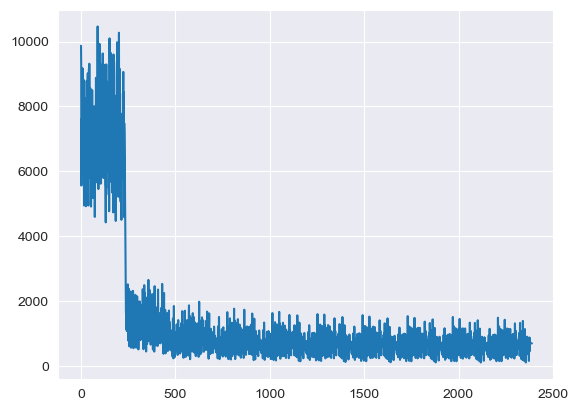

In [50]:
# plot the loss
import matplotlib.pyplot as plt

model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [25]:
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples from the original test set
    for i in range(5):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        print(f"{X_test_raw[i]} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

[ 48.           0.48706184 483.          19.          18.
   0.8231539    0.5426882   16.25         0.85526316   1.99122807] -> [1.0105023] (expected [0.9254386])
[210.           0.57542247 307.          17.          17.
   0.84011944   0.52637984  19.75         1.16176471   2.05882353] -> [0.5064845] (expected [0.5833333])
[4.01000000e+02 5.01120603e-01 5.59000000e+02 2.40000000e+01
 2.30000000e+01 8.38998211e-01 5.06926492e-01 1.90000000e+01
 7.91666667e-01 2.04513889e+00] -> [0.90756136] (expected [0.8506944])
[229.           0.59169124 365.          20.          19.
   0.83333333   0.51558659  23.           1.15         2.35833333] -> [0.5993472] (expected [0.59166664])
[183.           0.75821543 534.          19.          18.
   0.90870787   0.56833914  21.08333333   1.10964912   2.10964912] -> [0.9007012] (expected [0.7105263])


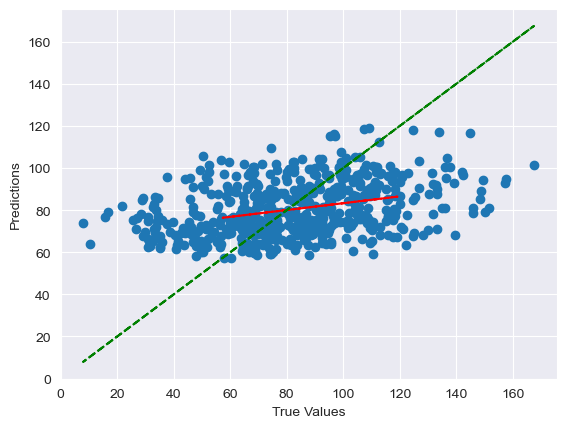

In [51]:
# plot the predictions as a scatter plot
y_pred = model(X_test)
y_pred = y_pred.detach().numpy()
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
# plot the line of best fit
# y_pred to 1D array
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_pred, p(y_pred), "r--")
# plot the line y=x
plt.plot(y_test, y_test, 'g--')
plt.show()

In [95]:
# get the importance of each feature
importance = model.fc1.weight.data.numpy()
# summarize feature importance
for i,v in enumerate(importance[0]):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.16279
Feature: 1, Score: -0.04942
Feature: 2, Score: 0.14793
Feature: 3, Score: 0.05046
Feature: 4, Score: 0.26305
Feature: 5, Score: -0.04709
Feature: 6, Score: 0.07518
Feature: 7, Score: 0.17553
Feature: 8, Score: 0.35536


In [27]:
# get the MAPE
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: %.2f" % mape)

# get the MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print("MAE: %.2f" % mae)

# get the MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)

# get the RMSE
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE: %.2f" % rmse)

# get the R2
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R2: %.2f" % r2)

# get the adjusted R2
n = len(y_test)
p = X_test.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("Adjusted R2: %.2f" % adj_r2)



MAPE: 0.28
MAE: 0.17
MSE: 0.05
RMSE: 0.22
R2: 0.24
Adjusted R2: 0.23


In [13]:
# save the model
torch.save(model.state_dict(), 'results/SA/models/NN_model_150e28.pth')

# save the scaler
import pickle
pickle.dump(scaler, open('results/SA/models/scaler_150e28.pkl', 'wb'))